# Feature extraction

With the segmented raw dataset, we can extract relevant features from it for modelling. 
Otherwise, we can skip this step, and use the segmented data directly.

In [2]:
import torch
import pickle
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler,RobustScaler
import random
from torch.autograd import Variable
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt
import pandas as pd
from copy import copy
import seaborn as sns
from sklearn.metrics import f1_score

from scipy.stats import skew
from scipy.stats import kurtosis
from scipy.fftpack import fft

import os

In [3]:
pickle_path = "pickles"
segmented_file_name = "segmented_inputs.p"

#dictionary which contains all phases, parts, sensors
segmented_data = pickle.load( open( pickle_path+"/"+segmented_file_name, "rb" ) )


In [4]:
print(segmented_data.keys())

#each segment has 81 parts

print(len(segmented_data['heating']))

#print one of the parts
print(segmented_data['heating'][0].shape)
segmented_data['heating'][0].head()

dict_keys(['heating', 'transfer', 'forging', 'full'])
81
(11011, 4)


,RamRetract_ActSpd [rpm],TMP_Ind_U1 [°C],IP_Out [%],L1.R_B41 [bar]
0,614.4,243.847656,-0.019531,34.663463
1,611.4,243.847656,-0.029297,34.407160
2,611.4,243.847656,-0.029297,34.656913
3,606.6,243.847656,-0.029297,34.957983
4,599.4,243.847656,-0.039062,35.035041


## Getting the features

Define a function to extract the features from each part's sensor data.

In [5]:
def get_features(x_dt,axis=1):
    feat_skewness = skew(x_dt,axis=axis)
    feat_kurtosis = kurtosis(x_dt,axis=axis)
    feat_mean = np.mean(x_dt,axis=axis)
    feat_std = np.std(x_dt,axis=axis)
    feat_min = np.min(x_dt,axis=axis)
    feat_max = np.max(x_dt,axis=axis)
    feat_sum = np.sum(x_dt,axis=axis)
    feat_median = np.median(x_dt,axis=axis)
    return[[feat_skewness,feat_kurtosis,feat_mean,feat_std,feat_min,feat_max,feat_sum,feat_median],["skewness","kurtosis","mean","std","min","max","sum","median"]]

In [6]:
features_data =[]
num_parts = len(segmented_data['heating'])
for part in range(num_parts):
    #add more segments here when necessary
    feature_data_heating,feature_heating_names=get_features(segmented_data['heating'][part].values,0)
    feature_data_forging,feature_forging_names=get_features(segmented_data['forging'][part].values,0)
    feature_data_full,feature_full_names=get_features(segmented_data['full'][part].values,0)

    
    feature_data_heating = np.array(feature_data_heating).reshape(-1)
    feature_data_forging = np.array(feature_data_forging).reshape(-1)
    feature_data_full = np.array(feature_data_full).reshape(-1)
    
    #feature_join = np.concatenate((feature_data_heating,feature_data_forging,feature_data_full))
    feature_join = np.concatenate((feature_data_heating,feature_data_forging))
    features_data.append(feature_join)
    
#feature_heating_names = [x+"_heating_"+str(i) for i in range(segmented_data['heating'][0].shape[1])]
#feature_forging_names = [x+"_forging_"+str(i) for i in range(segmented_data['forging'][0].shape[1])]

C:\Users\Administrator\Downloads\WinPython\python-3.6.5.amd64\lib\site-packages\scipy\stats\stats.py:1061: RuntimeWarning: invalid value encountered in true_divide
  lambda m2, m3: m3 / m2**1.5,


In [9]:
print(feature_data_heating.shape)
features_data = np.array(features_data)
print(features_data.shape)

(32,)
(81, 624)


In [10]:
#replace NaN
features_data = np.nan_to_num(features_data)

## Remove useless columns

Remove columns which are completely useless i.e totally the same for all parts

In [11]:
#remove useless columns
useless_columns = []
for col in range(features_data.shape[1]):
    if(np.unique(features_data[:,col]).shape[0]==1):
        useless_columns.append(col)

print("Number of useless columns: ",len(useless_columns))

if len(useless_columns) >0:
    print("Col #",useless_columns[0])
    print(features_data[:,useless_columns[0]])
    features_filtered= np.delete(features_data, useless_columns, axis=1)
    print("Removed ", str(features_data.shape[1]-features_filtered.shape[1])," columns")
   

Number of useless columns:  65
Col # 16
[599.4 599.4 599.4 599.4 599.4 599.4 599.4 599.4 599.4 599.4 599.4 599.4
 599.4 599.4 599.4 599.4 599.4 599.4 599.4 599.4 599.4 599.4 599.4 599.4
 599.4 599.4 599.4 599.4 599.4 599.4 599.4 599.4 599.4 599.4 599.4 599.4
 599.4 599.4 599.4 599.4 599.4 599.4 599.4 599.4 599.4 599.4 599.4 599.4
 599.4 599.4 599.4 599.4 599.4 599.4 599.4 599.4 599.4 599.4 599.4 599.4
 599.4 599.4 599.4 599.4 599.4 599.4 599.4 599.4 599.4 599.4 599.4 599.4
 599.4 599.4 599.4 599.4 599.4 599.4 599.4 599.4 599.4]
Removed  65  columns


In [12]:
print(feature_data_heating.shape)
print(feature_data_forging.shape)
print(feature_join.shape)
print(features_data.shape)
print(features_filtered.shape)

(32,)
(592,)
(624,)
(81, 624)
(81, 559)


In [13]:
pickle_path = "pickles"
features_file_name = "features_data.p"

if pickle_path not in os.listdir():
    os.mkdir(pickle_path)

#save into pickle file
pickle.dump(features_filtered, open( pickle_path+"/"+features_file_name, "wb" ) )

## Optional: Visualize the some of features


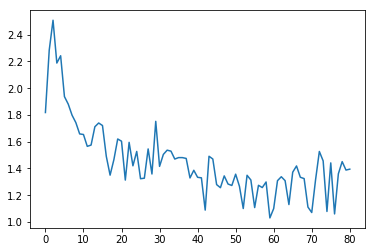

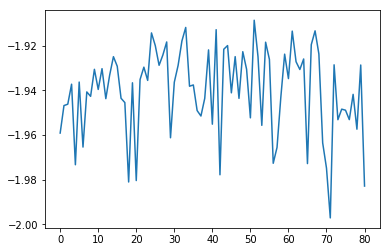

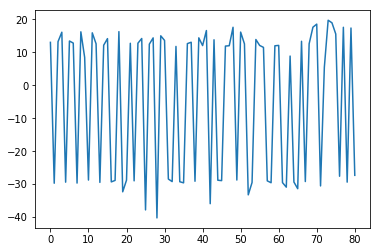

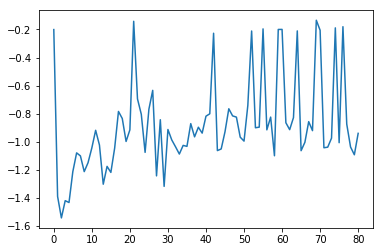

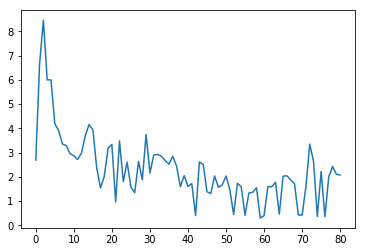

<Figure size 432x288 with 0 Axes>

In [14]:
num_features_visualize =5
for i in range(num_features_visualize):
    plt.plot(features_data[:,i])
    plt.show()
    plt.clf()